### Based
https://www.kaggle.com/code/umar47/detect-ai-eda-tensorflow-0-90?scriptVersionId=152526428  

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import string
import tensorflow_text as tf_text

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [21]:
#train = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
extra_train = pd.read_csv("/kaggle/input/ai-generated-vs-human-generated/merge.csv")
#extra_train_new = pd.read_csv("/kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv")
test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
#train_prompts = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')

In [24]:
#train_final = pd.concat([extra_train_f, train.drop(columns=['prompt_id', 'id'], axis=0)], axis=0).reset_index(drop=True).drop_duplicates()
train_final = extra_train
train_final

,Unnamed: 0,prompt_name,text,generated,source,file
0,0,Phones and driving,Phones\n\nModern humans today are always on th...,0,persuade_corpus,daigt-v2-train-dataset/train_v2_drcat_02.csv
1,1,Phones and driving,This essay will explain if drivers should or s...,0,persuade_corpus,daigt-v2-train-dataset/train_v2_drcat_02.csv
2,2,Phones and driving,Driving while the use of cellular devices\n\nT...,0,persuade_corpus,daigt-v2-train-dataset/train_v2_drcat_02.csv
3,3,Phones and driving,Phones & Driving\n\nDrivers should not be able...,0,persuade_corpus,daigt-v2-train-dataset/train_v2_drcat_02.csv
4,4,Phones and driving,Cell Phone Operation While Driving\n\nThe abil...,0,persuade_corpus,daigt-v2-train-dataset/train_v2_drcat_02.csv
...,...,...,...,...,...,...
190339,190339,Does the electoral college work?,The electoral college iyitem ii a central aip...,1,NaN,llm-mistral-7b-instruct-texts/Mistral7B_CME_v7...
190340,190340,Does the electoral college work?,The electoral college iyitem ii a method uied...,1,NaN,llm-mistral-7b-instruct-texts/Mistral7B_CME_v7...
190341,190341,Does the electoral college work?,The elecioral college ii a iyiiem uied in ihe...,1,NaN,llm-mistral-7b-instruct-texts/Mistral7B_CME_v7...
190342,190342,Does the electoral college work?,The electoral college is a group of people ap...,1,NaN,llm-mistral-7b-instruct-texts/Mistral7B_CME_v7...


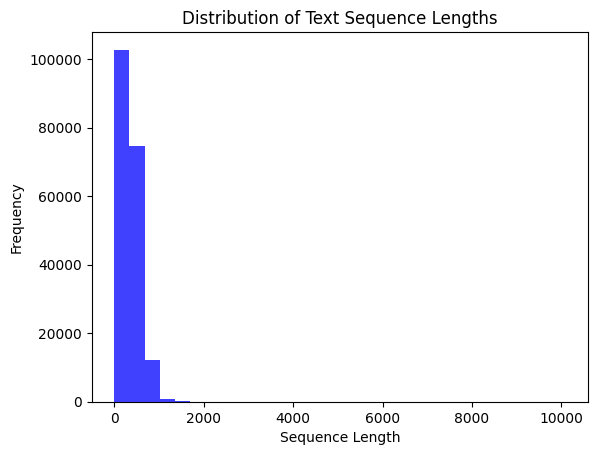

In [25]:
import matplotlib.pyplot as plt
sequence_lengths = train_final['text'].apply(lambda x: len(x.split()))

plt.hist(sequence_lengths, bins=30, alpha=0.75, color='blue')
plt.title('Distribution of Text Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

In [26]:
print(train_final['generated'].value_counts())

generated
1    124308
0     66036
Name: count, dtype: int64


In [27]:
train_df, val_df = train_test_split(train_final, test_size=0.3, random_state=222)

batch_size = 32

raw_train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['text'].values, train_df['generated'].values)
).batch(batch_size)

raw_val_ds = tf.data.Dataset.from_tensor_slices(
    (val_df['text'].values, val_df['generated'].values)
).batch(batch_size)

In [28]:
max_features = 75000
embedding_dim = 64
sequence_length = 512

def tf_lower_and_split_punct(text):
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text


# Text vectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_features,
    ngrams = (3,5),
    output_mode="int",
    output_sequence_length=sequence_length,
    pad_to_max_tokens=True
)

text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

In [29]:
from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras import Model, Input

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [30]:
inputs = Input(shape=(sequence_length,), dtype="int64")
x = Embedding(max_features, embedding_dim)(inputs)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
transformer_block = TransformerBlock(embedding_dim, 2, 32)
x = transformer_block(x)
x = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid", name="predictions")(x)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 512, 64)           4800000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 512, 64)          24832     
 nal)                                                            
                                                                 
 transformer_block_1 (Transf  (None, 512, 64)          37664     
 ormerBlock)                                                     
                                                                 
 conv1d_1 (Conv1D)           (None, 169, 128)          57472     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0   

In [35]:
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=[AUC(name='roc_auc')])

epochs = 10
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
4164/4164 [==============================] - 503s 119ms/step - loss: 0.1777 - roc_auc: 0.9764 - val_loss: 0.2863 - val_roc_auc: 0.9598
Epoch 2/10
4164/4164 [==============================] - 232s 56ms/step - loss: 0.1276 - roc_auc: 0.9881 - val_loss: 0.3687 - val_roc_auc: 0.9483
Epoch 3/10
4164/4164 [==============================] - 231s 55ms/step - loss: 0.0896 - roc_auc: 0.9939 - val_loss: 0.3789 - val_roc_auc: 0.9544
Epoch 4/10
4164/4164 [==============================] - 230s 55ms/step - loss: 0.0644 - roc_auc: 0.9967 - val_loss: 0.3418 - val_roc_auc: 0.9568
Epoch 5/10
4164/4164 [==============================] - 229s 55ms/step - loss: 0.0481 - roc_auc: 0.9980 - val_loss: 0.5399 - val_roc_auc: 0.9471
Epoch 6/10
4164/4164 [==============================] - 223s 53ms/step - loss: 0.0375 - roc_auc: 0.9987 - val_loss: 0.5564 - val_roc_auc: 0.9406
Epoch 7/10
4164/4164 [==============================] - 221s 53ms/step - loss: 0.0283 - roc_auc: 0.9992 - val_loss: 0.7812 - val_

In [37]:
model.save("llm_model.h5")

In [38]:
test_text = test['text'].values
vectorized_test_text = vectorize_layer(test_text)
predictions = model.predict(vectorized_test_text)
test['generated'] = predictions
print(test[['text', 'generated']])

1/1 [==============================] - 1s 839ms/step
           text  generated
0  Aaa bbb ccc.   0.357206
1  Bbb ccc ddd.   0.357206
2  CCC ddd eee.   0.357206


In [39]:
test[['id', 'generated']].set_index('id').to_csv("submission.csv")